# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Напишите заголовок первой части проекта здесь

- Автор: Коваленко Николай Евгеньевич
- Дата: 07.04.2025

## Цели и задачи проекта

- Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп и их статистики.
- Статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

## Описание данных

***Датасет yandex_knigi_data***: 
- number - номер
- city - город, 
- puid - id 
- hours - количество часов.

***Таблица участников теста ab_test_participants.csv***:

- user_id — идентификатор пользователя;
- group — группа пользователя;
- ab_test — название теста;
- device — устройство, с которого происходила регистрация.

***Таблица ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года***:

- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии.

***Дополнительная информация по столбцу `details`***:

- registration (регистрация) — стоимость привлечения клиента;
- purchase (покупка) — стоимость покупки.

## Содержимое проекта

<font color='#777778'>Перечислите основные шаги проекта или напишите оглавление. Используйте описание проекта, чтобы зафиксировать основные шаги.</font>

- Загрузка данных
- Проверка гипотезы в Python
- Аналитическая записка
- Анализ результатов А/Б тестирования
- Проведение оценки результатов А/Б тестирования

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_effectsize
plt.rcParams["figure.figsize"] = (12,8) 

In [150]:
df_knigi=pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [151]:
#Проверка явных дубликатов
unique_users = df_knigi['puid'].nunique()
row_count_1 = df_knigi.duplicated().sum() 
row_count_2 = len(df_knigi) 
print(f"Количество строк в DataFrame: {row_count_2}")
print(f"Количество дублированных строк в DataFrame: {row_count_1}")
print(f"Количество уникальных пользователей: {unique_users}")

Количество строк в DataFrame: 8784
Количество дублированных строк в DataFrame: 0
Количество уникальных пользователей: 8540


In [152]:
# 1. Проверить, есть ли дубликаты (True/False)
are_there_duplicates = df_knigi['puid'].duplicated().any()
print("Есть дубликаты в столбце 'puid'? -", are_there_duplicates)

# 2. Показать конкретные строки, которые являются дубликатами
duplicate_rows = df_knigi[df_knigi['puid'].duplicated(keep=False)]
print("Строки с дубликатами:\n", duplicate_rows)

Есть дубликаты в столбце 'puid'? - True
Строки с дубликатами:
       Unnamed: 0             city              puid      hours
35            35           Москва           2637041  10.317371
134          134           Москва           9979490  32.415573
145          145           Москва          10597984  42.931506
150          150           Москва          10815097   9.086655
187          187           Москва          13626259  21.104167
...          ...              ...               ...        ...
8771        8771  Санкт-Петербург  1130000018516717   0.517778
8772        8772  Санкт-Петербург  1130000018954257  33.583294
8773        8773  Санкт-Петербург  1130000020425037   2.386944
8775        8775  Санкт-Петербург  1130000023864516  14.384722
8779        8779  Санкт-Петербург  1130000028554332   4.107774

[488 rows x 4 columns]


In [153]:
#Удаляем повторящиеся idшники
df = df_knigi[~df_knigi['puid'].duplicated(keep=False)]

In [154]:
df.describe()

,Unnamed: 0,puid,hours
count,8296.000000,8.296000e+03,8296.000000
mean,4346.692261,8.990784e+12,10.963892
std,2525.732392,1.003939e+14,37.753906
min,0.000000,9.668000e+03,0.000022
25%,2170.750000,3.251976e+08,0.057493
50%,4336.500000,8.894445e+08,0.884214
75%,6492.250000,1.523879e+09,5.944675
max,8783.000000,1.130000e+15,978.764775


**Вывод**: После удаления явных и неявных дубликатов датафрейм сократился с 8784 осталось 8296 элементов со средним 10,96 часосв, <br>
стандартным отклонением 37,75.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не больше.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [157]:
# Сформируем датасеты
group_msk_data = df[df['city']=='Москва'].hours

group_spb_data = df[df['city']=='Санкт-Петербург'].hours

**Вывод**: Выборка по Москве 5990 против 2306 в СПБ, среднее у них примерно одинакове 10,84 против 11,26, стандартное отклонение в Питере выше 39,83 против 36,92 в Москве.

In [159]:
print(f'Москва - среднее {group_msk_data.mean()}, стандартное отклонение {group_msk_data.std()}')
print(f'CПб - среднее {group_spb_data.mean()}, стандартное отклонение {group_spb_data.std()}')

Москва - среднее 10.84819150713916, стандартное отклонение 36.925621960682996
CПб - среднее 11.264433367029522, стандартное отклонение 39.83175458739666


In [160]:
group_msk_data.describe()

count    5990.000000
mean       10.848192
std        36.925622
min         0.000022
25%         0.057042
50%         0.888232
75%         5.933439
max       857.209373
Name: hours, dtype: float64

In [161]:
group_spb_data.describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

In [162]:
# Creating a dictionary by passing Series objects as values
frame = {'index': group_msk_data.index,
         'hours': group_msk_data}
 
# Creating DataFrame by passing Dictionary
group_msk_data_1 = pd.DataFrame(frame)

In [163]:
# Creating a dictionary by passing Series objects as values
frame_1 = {'index': group_spb_data.index,
         'hours': group_spb_data}
 
# Creating DataFrame by passing Dictionary
group_spb_data_1 = pd.DataFrame(frame_1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13332\875827916.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([group_msk_data_1['hours'], group_spb_data_1['hours']],


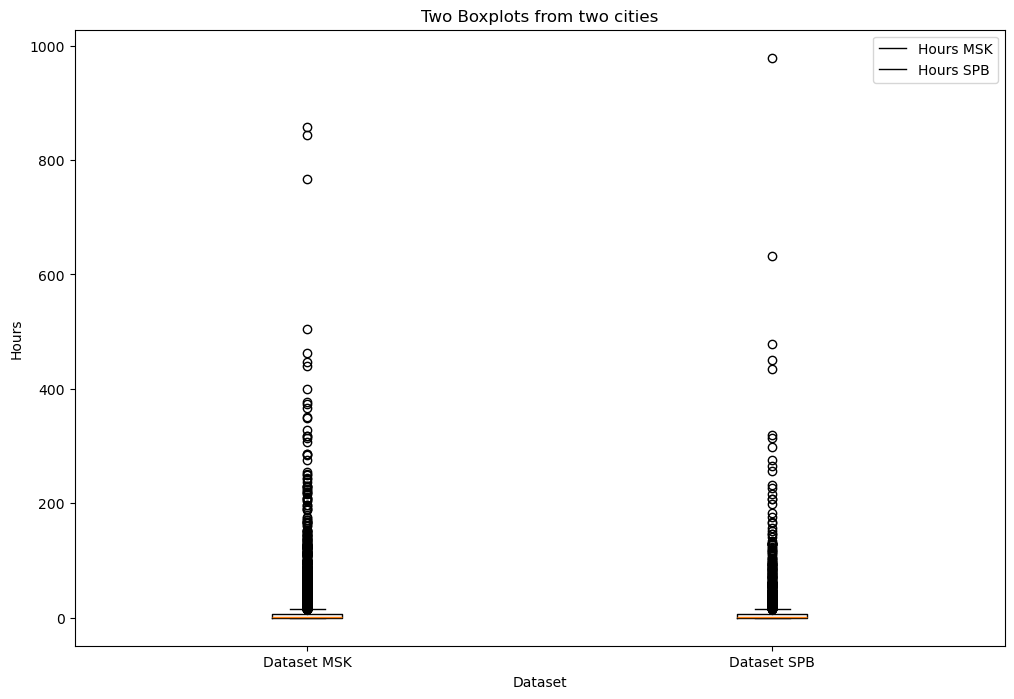

In [164]:
# Строим boxplot сразу для двух наборов данных
box = plt.boxplot([group_msk_data_1['hours'], group_spb_data_1['hours']], 
                  labels=['Dataset MSK', 'Dataset SPB'])

# Добавим заголовок и подписи осей
plt.title("Two Boxplots from two cities")
plt.xlabel("Dataset")
plt.ylabel("Hours")

# Необязательная легенда (для boxplot легенду обычно вручную):
plt.legend([box["boxes"][0], box["boxes"][1]],
           ['Hours MSK', 'Hours SPB'])

plt.show()

***T-тест (или критерий Стьюдента)*** <br> 
один из самых распространённых статистических критериев для проверки гипотез. <br>
Для проведения двухвыборочного t-теста должны выполняться следующие условия:
- нормальность выборочного среднего;
- независимость наблюдений;
- равенство выборочных дисперсий.
- отсутствие выбросов

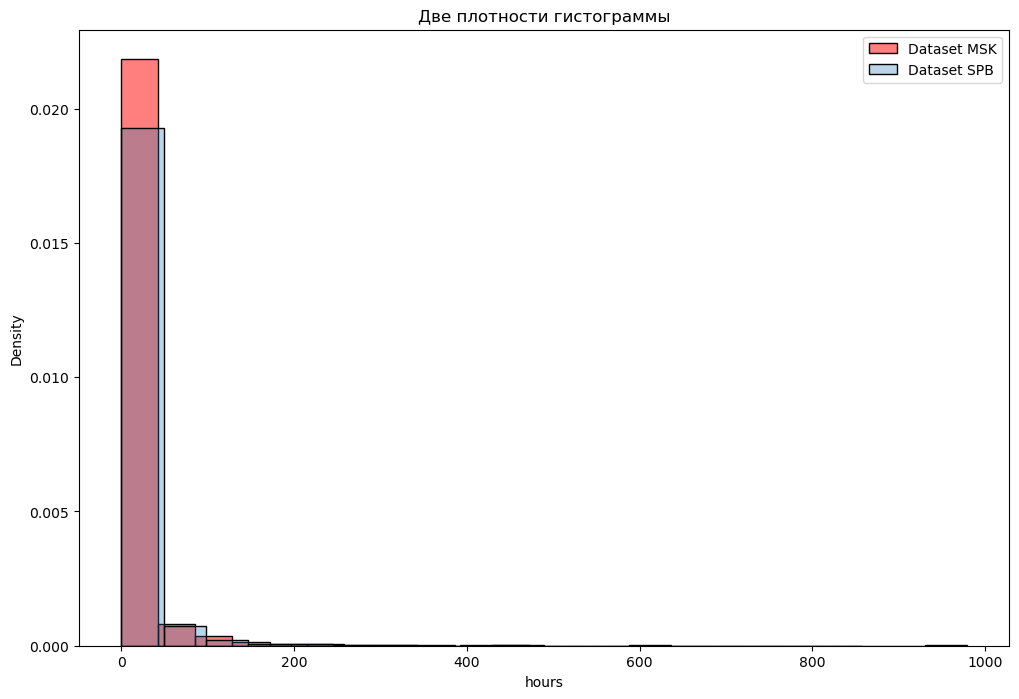

In [166]:
# Построим гистограмму для df1
sns.histplot(
    data=group_msk_data_1,
    x='hours',
    stat='density',    # плотность, аналог 'density=True' в Matplotlib
    common_norm=False, # не делать нормировку совместной (каждый набор нормируется отдельно)
    bins=20,
    alpha=0.5,
    color='red',# полупрозрачность, чтобы оба распределения лучше различать
    label='Dataset MSK'
)

# Построим гистограмму для df2
sns.histplot(
    data=group_spb_data_1,
    x='hours',
    stat='density',
    common_norm=False,
    bins=20,
    alpha=0.3,
    label='Dataset SPB'
)

plt.title("Две плотности гистограммы")
plt.xlabel("hours")
plt.ylabel("Density")
plt.legend()

plt.show()

***Вывод***: Можно говорить о том что даспределения по обоим городам достаточно похожи, так как на верхнем графике при отмечании разными цветами они достаточно однотипно прокрашиваются, также этот факт подтвержает boxplot.

Нулевая гипотеза H₀: Группы (Москва/Санкт-Петербург) брались из нормального распределения.

Альтернативная гипотеза H₁: Группы (Москва/Санкт-Петербург) брались из не нормального распределения.

In [169]:
x = np.concatenate((group_msk_data,group_spb_data))
res = st.normaltest(x)

print(f'{res.statistic} - статистика, {res.pvalue} p-value')

13272.932943976733 - статистика, 0.0 p-value


In [170]:
res_msk = st.normaltest(group_msk_data)

print(f'{res_msk.statistic} - статистика, {res_msk.pvalue} p-value')

9317.515953533974 - статистика, 0.0 p-value


In [171]:
res_spb = st.normaltest(group_spb_data)

print(f'{res_spb.statistic} - статистика, {res_spb.pvalue} p-value')

3938.761150755944 - статистика, 0.0 p-value


In [172]:
#Уровень значимости
alpha=0.05

**Вывод**: Проверим данные на наличие выбросов, в случаи их нахождения это будет основанием для применим тест Манна-Уитни.

Подтвердим наличие выбросов в обеих группах

In [175]:
# Вычисляем Z-оценки
z_scores_msk = st.zscore(group_msk_data_1['hours'])

# Определяем выбросы (обычно Z-оценка > 3 или < -3)
outliers_msk=group_msk_data_1[(z_scores_msk > 3) | (z_scores_msk < -3)]

print(outliers_msk.shape[0])

105


In [176]:
# Вычисляем Z-оценки
z_scores_spb = st.zscore(group_spb_data_1['hours'])

# Определяем выбросы (обычно Z-оценка > 3 или < -3)
outliers_spb=group_spb_data_1[(z_scores_spb > 3) | (z_scores_spb < -3)]

print(outliers_spb.shape[0])

29


Основная предпосылки теста Манна-Уитни: 
- у нас есть две независимые выборки данных, каждая — набор наблюдений (как правило, непрерывных или ранговых).
  Не требуется предположения о нормальности распределений (поэтому тест Манна–Уитни часто используют, когда нельзя применить t-   критерий Стьюдента). Ранее было показано, что данные не являются данными из нормального распределения.
- Тест чувствителен именно к «сдвигу» (например, различию медиан) в случае, если формы распределений похожи. Если формы распределений кардинально отличаются, результат говорит о разнице в распределениях, но интерпретация «разницы средних» или «разницы медиан» становится менее очевидной.

In [178]:
mw_test = st.mannwhitneyu(
    group_spb_data,
    group_msk_data, # Выборка значений метрики для группы А
    # Выборка значений метрики для группы B
    alternative='greater' # Выбираем двустороннюю гипотезу 
                            # alternative='less' соответствует альтернативной гипотезе: Dist(a)<Dist(b)
                            # alternative='greater' соответствует альтернативной гипотезе: Dist(a)>Dist(b)
)

In [179]:
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах МСК и СПБ равны')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах МСК и СПБ различаются')

pvalue=0.4532273739367588 > 0.05
Нулевая гипотеза находит подтверждение! Распределения метрики в группах МСК и СПБ равны


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



- Был выбран тест Манна-Уитни, в качестве уровня знаимости было выбрано 5%
- pvalue=0.4532273739367588
- Мы не можем отвергнуть гипотезу о равенстве метрик в Москве и СПб
- Обе выборки являются данным похожей структуры, что видно визуально из boxplot|гистограммы и статистически на основе собранных описательных статистик, можно говорить что привычки к чтению у жителей Москвы и Санкт-Петербурга похожи. Более полная картина у нас была бы если бы имели данные о пользовательской информации пол, возраст, привычки.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.
Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

## 2. Загрузите данные, оцените их целостность.


In [188]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

Первые строки

In [190]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [191]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Типы данных

In [193]:
participants.dtypes

user_id    object
group      object
ab_test    object
device     object
dtype: object

In [194]:
events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name            object
details               object
dtype: object

Пропуски

In [196]:
print(participants.isna().sum())

user_id    0
group      0
ab_test    0
device     0
dtype: int64


In [197]:
print(events.isna().sum())

user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64


Дубликаты

In [199]:
#Проверка явных дубликатов
unique_users_ev = events['user_id'].nunique()
row_count_ev_1 = events.duplicated().sum() 
row_count_ev_2 = len(events) 
print(f"Количество строк в DataFrame: {row_count_ev_2}")
print(f"Количество дублированных строк в DataFrame: {row_count_ev_1}")
print(f"Количество уникальных пользователей: {unique_users_ev}")

Количество строк в DataFrame: 787286
Количество дублированных строк в DataFrame: 36318
Количество уникальных пользователей: 144184


In [200]:
#Удаляем дубликаты
events=events.drop_duplicates(keep='last')

In [201]:
#Проверка явных дубликатов
unique_users_pa = participants['user_id'].nunique()
row_count_pa_1 = participants.duplicated().sum() 
row_count_pa_2 = len(participants) 
print(f"Количество строк в DataFrame: {row_count_pa_2}")
print(f"Количество дублированных строк в DataFrame: {row_count_pa_1}")
print(f"Количество уникальных пользователей: {unique_users_pa}")

Количество строк в DataFrame: 14525
Количество дублированных строк в DataFrame: 0
Количество уникальных пользователей: 13638


## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [203]:
#Разбиваем участников на тесты
df_eu=participants[participants['ab_test']=='interface_eu_test'].copy()
df_sys=participants[participants['ab_test']=='recommender_system_test'].copy()

In [204]:
print(len(df_eu))
print(len(df_sys))

10850
3675


In [205]:
#датасет для объединенной диаграммы
df_part=df_eu.pivot_table(index='device', columns='group', values='user_id', aggfunc='nunique').reset_index()

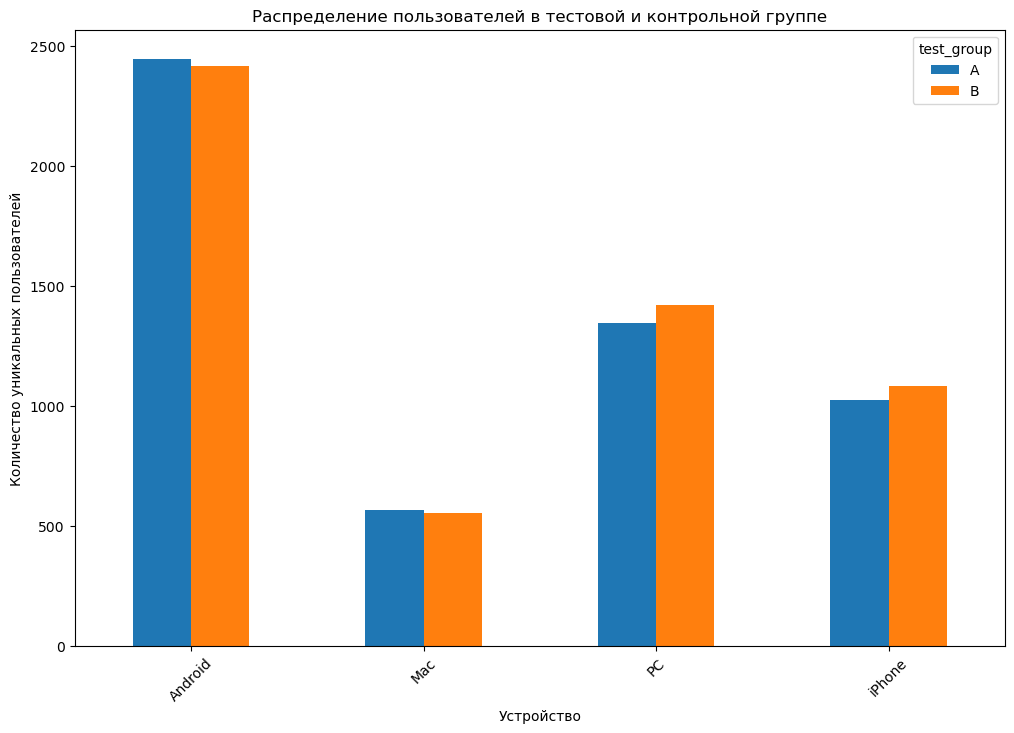

In [206]:
# Строим столбчатую диаграмму
df_part.plot(kind='bar', x='device', y=['A', 'B'])

# Добавляем подписи к осям и заголовок
plt.xlabel('Устройство')
plt.ylabel('Количество уникальных пользователей')
plt.title('Распределение пользователей в тестовой и контрольной группе')

# Показываем график

plt.xticks(rotation=45)
plt.legend(title='test_group')
plt.show()

In [207]:
# Нахождение пересечения по user_id
intersection = pd.merge(df_eu[df_eu['group']=='A'], df_eu[df_eu['group']=='B'], on='user_id', how='inner')

# Вывод результата
print("Количество пользователей в пересечении:", len(intersection))

Количество пользователей в пересечении: 0


In [208]:
# Нахождение пересечения по user_id
intersection_2 = pd.merge(df_eu[df_eu['group']=='B'], df_sys[df_sys['group']=='B'], on='user_id', how='inner')

# Вывод результата
print("Количество пользователей в пересечении:", len(intersection_2))

Количество пользователей в пересечении: 116


In [209]:
# Удаляем строки, где user_id из пересечения_2
df_eu_2 = df_eu[~df_eu['user_id'].isin(intersection_2)]

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [211]:
fil_df = events[events["user_id"].isin(df_eu_2["user_id"])]

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [213]:
# Фильтрация событий регистрации
registration_dates = fil_df[fil_df['event_name'] == 'registration'][['user_id', 'event_dt']]

# Переименование столбца для удобства

registration_dates = (
    registration_dates.groupby('user_id', as_index=False)['event_dt']
      .min()                      # минимальная дата в группе
      .rename(columns={'event_dt': 'registration_dt'})
)
print(registration_dates.head())

            user_id     registration_dt
0  0002CE61FF2C4011 2020-12-07 04:37:31
1  001064FEAAB631A1 2020-12-20 14:12:45
2  001E72F50D1C48FA 2020-12-17 15:44:05
3  002412F1EB3F6E38 2020-12-09 09:36:50
4  002540BE89C930FB 2020-12-08 18:06:07


In [214]:
# Объединение по user_id
df_all = pd.merge(fil_df, registration_dates, on='user_id', how='inner')

In [215]:
# Убедитесь, что столбцы в формате datetime
df_all['event_dt'] = pd.to_datetime(df_all['event_dt'], errors='ignore')
df_all['registration_dt'] = pd.to_datetime(df_all['registration_dt'], errors='ignore')

# Расчёт лайфтайма
df_all['lifetime'] = (df_all['event_dt'] - df_all['registration_dt']).dt.days

# Фильтрация событий, произошедших в первые 7 дней
df_filtered = df_all[df_all['lifetime'] <= 7]

print(df_filtered.head())

            user_id            event_dt    event_name details  \
0  5F506CEBEDC05D30 2020-12-06 14:10:01  registration     0.0   
1  51278A006E918D97 2020-12-06 14:37:25  registration    -3.8   
2  A0C1E8EFAD874D8B 2020-12-06 17:20:22  registration   -3.32   
3  275A8D6254ACF530 2020-12-06 19:36:54  registration   -0.48   
4  0B704EB2DC7FCA4B 2020-12-06 19:42:20  registration     0.0   

      registration_dt  lifetime  
0 2020-12-06 14:10:01         0  
1 2020-12-06 14:37:25         0  
2 2020-12-06 17:20:22         0  
3 2020-12-06 19:36:54         0  
4 2020-12-06 19:42:20         0  


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13332\1839101381.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df_all['event_dt'] = pd.to_datetime(df_all['event_dt'], errors='ignore')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13332\1839101381.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df_all['registration_dt'] = pd.to_datetime(df_all['registration_dt'], errors='ignore')


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [217]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
base_conversion = 0.30  # Базовая конверсия
expected_increase = 0.03  # Ожидаемый прирост (3 п.п.)

# Рассчитываем размер эффекта для пропорций
effect_size = proportion_effectsize(base_conversion, base_conversion + expected_increase)  # Минимальный детектируемый эффект посчитанный согласно формуле

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


**Вывод**:
Есть достаточный объем выборки для проведения АБ-тестирования.

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [220]:
df_final=pd.merge(df_eu, df_filtered, on='user_id', how='inner')

In [221]:
# 1. Считаем общее кол-во уникальных пользователей в каждой группе
total_users_by_group = df_final.groupby('group')['user_id'].nunique()

# 2. Считаем, сколько уникальных пользователей совершили purchase
purchase_df = df_final[df_final['event_name'] == 'purchase']
purchased_users_by_group = purchase_df.groupby('group')['user_id'].nunique()

# Формируем итоговую таблицу
summary_df = pd.DataFrame({
    'total_users': total_users_by_group,
    'purchased_users': purchased_users_by_group
})

summary_df

,total_users,purchased_users
group,,
A,5383,1542
B,5467,1687


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [223]:
print(f'Пользователи в тестовой выборке стали чаще покупать \
{round(100*summary_df.loc["A", "purchased_users"]/summary_df.loc["A", "total_users"],2)} \
в контрольной против {round(100*summary_df.loc["B", "purchased_users"]/summary_df.loc["B", "total_users"],2)} в тестовой')

Пользователи в тестовой выборке стали чаще покупать 28.65 в контрольной против 30.86 в тестовой


## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Гипотеза
H₀ (нулевая гипотеза) — конверсия продаж в тестовой группе не больше, чем в контрольной. <br>
H₁ (альтернативная гипотеза) — конверсия продаж в тестовой группе больше, чем в контрольной группе

In [227]:
n_a = summary_df.loc["A", "total_users"]  
n_b = summary_df.loc["B", "total_users"] 

m_a = summary_df.loc["A", "purchased_users"] 

m_b = summary_df.loc["B", "purchased_users"] 

p_a, p_b = m_a/n_a, m_b/n_b # посчитайте доли успехов для каждой группы: A и B
dif=p_b-p_a

In [228]:
alpha = 0.05  ## установите уровень значимости

stat_ztest, p_value_ztest = proportions_ztest( # проведите Z-тест пропорций
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

In [229]:
print(f'pvalue={p_value_ztest}') # выведите полученное p-value 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
    print('Интерпретация: новый интрефейс не увеличил ключевую метрику — долю продаж')
else:
    print('Нулевая гипотеза не находит подтверждения!')
    print('Интерпретация: новый интерфейс увеличил ключевую метрику — долю продаж')

pvalue=0.005870328999063137
Нулевая гипотеза не находит подтверждения!
Интерпретация: новый интерфейс увеличил ключевую метрику — долю продаж


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

***Вывод***:
В рамках исследования мы можем говорить, что новый интерфейс сайта статистически значимо повышает ковнерсию продаж. Z-тест смог отвергнуть нулевую гипотезу, был отмечен рост в 2.2 п.п. Целевая метрика в 3 п.п. не была достигнута.